# Training

- Use this notebook after you've built your dataset to train the model.
- Training will create a model directory with:
    - **`model_0000XXX.pth`**: weights that are regularly saved during training
    - **`config.yaml`**: the model configuration used during the last training performed.
    - **`training.log`**: a log file that contains all the logs displayed in the notebook during training (useful if you close your notebook during a long training session).

In [2]:
%env CUDA_VISIBLE_DEVICES=0
%load_ext autoreload
%autoreload 2
%matplotlib inline

from pathlib import Path
import logging

import matplotlib.pyplot as plt
import numpy as np

import sys; sys.path.append("../")
import maskflow

root_dir = Path("/home/hadim/.data/Neural_Network/Maskflow/C_elegans")
data_dir = root_dir / "Data"
model_dir = root_dir / "Models"
model_dir.mkdir(exist_ok=True)

# Import the configuration associated with this dataset and network.
config = maskflow.config.load_config(root_dir / "config.yaml")

env: CUDA_VISIBLE_DEVICES=0
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Check Dataset

loading annotations into memory...
Done (t=0.24s)
creating index...
index created!


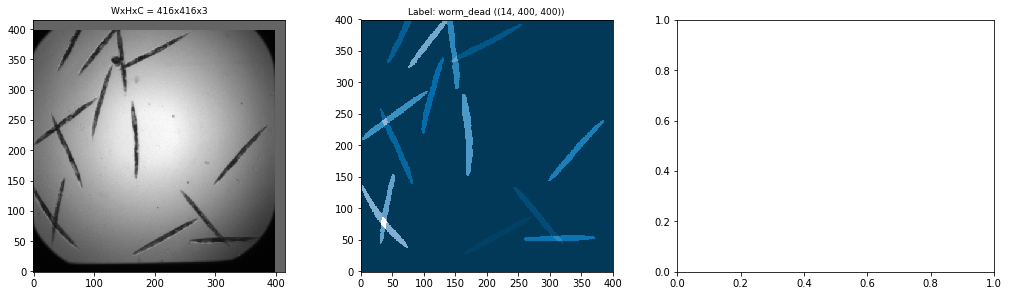

In [3]:
config['SOLVER']['IMS_PER_BATCH'] = 1
n_batch = 1

# Load some data
data_loader = maskflow.dataset.get_data_loader(config, data_dir, is_train=True)
some_data = [iter(data_loader).next() for _ in range(n_batch)]

# Retrieve category's names
categories = data_loader.dataset.coco.cats

for batch_image, batch_target, batch_idx in some_data:
    maskflow.viz.batch_display_top_masks(batch_image, batch_target, batch_idx, categories,
                                         basesize=14, limit=2, cmap="PuBu_r",
                                         pixel_mean=config['INPUT']['PIXEL_MEAN'],
                                         pixel_std=config['INPUT']['PIXEL_STD'])

## Training

In [4]:
# Configure the training
config['DATA_DIR'] = str(data_dir)

config['MODEL']['DEVICE'] = "cuda"

config['DATALOADER']['NUM_WORKERS'] = 16
config['SOLVER']['IMS_PER_BATCH'] = 8

# Disable those settings if you want to use the training
# parameters from your config file.
custom_training = True
if custom_training:
    max_iter = 1000
    config['SOLVER']['MAX_ITER'] = max_iter
    config['SOLVER']['BASE_LR'] = 0.0025
    config['SOLVER']['STEPS'] = [int(max_iter * 0.66), int(max_iter * 0.9)]
    config['SOLVER']['CHECKPOINT_PERIOD'] = 250
    config['SOLVER']['WARMUP_ITERS'] = 50

#config['SOLVER']

In [5]:
# Setup training

# Use the last model in the model dir
# If False, create a new model from scratch.
# If `model_to_use` is set, we use this one instead.

builder_args = {}
builder_args['config'] = config
builder_args['model_dir'] = model_dir
builder_args['use_last_model'] = False
builder_args['model_to_use'] = None
builder_args['use_pretrained_weights'] = True

training_args = maskflow.training.build_model(**builder_args)

2018-11-10 23:30:55,873:INFO:root: Training model directory set: /home/hadim/.data/Neural_Network/Maskflow/C_elegans/Models/2018.11.10-23:30:55
2018-11-10 23:30:55,874:INFO:root: Building the model...
2018-11-10 23:31:17,051:INFO:root: Use pretrained weights from https://download.pytorch.org/models/maskrcnn/e2e_mask_rcnn_R_50_FPN_1x.pth
2018-11-10 23:31:18,688:INFO:maskrcnn_benchmark.utils.checkpoint: No checkpoint found. Initializing model from scratch
2018-11-10 23:31:18,695:INFO:maskrcnn_benchmark.utils.checkpoint: Saving checkpoint to /home/hadim/.data/Neural_Network/Maskflow/C_elegans/Models/2018.11.10-23:30:55/model_0000000.pth
2018-11-10 23:31:19,009:INFO:root: Create the data loader.
2018-11-10 23:31:19,012:WARNING:maskrcnn_benchmark.data.build: When using more than one image per GPU you may encounter an out-of-memory (OOM) error if your GPU does not have sufficient memory. If this happens, you can reduce SOLVER.IMS_PER_BATCH (for training) or TEST.IMS_PER_BATCH (for inference)

loading annotations into memory...
Done (t=0.22s)
creating index...
index created!


In [ ]:
# Run training

training_args['log_period'] = 10
training_args['log_losses_detailed'] = False
training_args['save_metrics'] = True
training_args['tensorboard'] = True
training_args['tensorboard_log_period'] = 10

maskflow.training.do_train(**training_args)

2018-11-10 23:31:19,340:INFO:maskfow.training: Start training at iteration 0
2018-11-10 23:31:19,781:INFO:maskfow.training: tensorboard --logdir /home/hadim/.data/Neural_Network/Maskflow/C_elegans/Models/2018.11.10-23:30:55/logs
2018-11-10 23:31:19,785:INFO:maskfow.training: Training will stop at 1000
2018-11-10 23:31:26,967:INFO:maskfow.training: Step: 0 | Loss: 4.447212 | ETA: 1:49:18 | LR: 0.000825 | Memory: 3307 MB
2018-11-10 23:31:54,739:INFO:maskfow.training: Step: 10 | Loss: 2.059038 | ETA: 0:51:27 | LR: 0.001160 | Memory: 5563 MB
2018-11-10 23:32:29,755:INFO:maskfow.training: Step: 20 | Loss: 1.756161 | ETA: 0:53:58 | LR: 0.001495 | Memory: 6124 MB
2018-11-10 23:33:11,468:INFO:maskfow.training: Step: 30 | Loss: 1.291708 | ETA: 0:57:53 | LR: 0.001830 | Memory: 6604 MB
2018-11-10 23:33:48,918:INFO:maskfow.training: Step: 40 | Loss: 1.096091 | ETA: 0:57:57 | LR: 0.002165 | Memory: 6792 MB
2018-11-10 23:34:23,042:INFO:maskfow.training: Step: 50 | Loss: 1.042421 | ETA: 0:56:41 | LR: